# Residual Networks (ResNet)

As we design increasingly deeper networks it becomes imperative to understand how adding layers can
increase the complexity and expressiveness of the network. Even more important is the ability to design
networks where adding layers makes networks strictly more expressive rather than just different. To make
some progress we need a bit of theory.

## Function Classes

Consider F, the class of functions that a specific network architecture (together with learning rates and
other hyperparameter settings) can reach. That is, for all f ∈ F there exists some set of parameters W that
can be obtained through training on a suitable dataset. Let’s assume that f∗ is the function that we really
would like to find. If it’s in F, we’re in good shape but typically we won’t be quite so lucky. Instead, we
will try to find some fF∗ which is our best bet within F. For instance, we might try finding it by solving the
following optimization problem:
                     
                     fF∗ := argmin L(X,Y,f) subject to f ∈ F 

It is only reasonable to assume that if we design a different and more powerful architecture F′ we should
arrive at a better outcome. In other words, we would expect that fF∗′ is ‘better’ than fF∗ . However, if F ̸⊆ F′
there is no guarantee that this should even happen. In fact, fF∗′ might well be worse. This is a situation
that we often encounter in practice - adding layers doesn’t only make the network more expressive, it also
changes it in sometimes not quite so predictable ways. The picture below illustrates this in slightly abstract
terms.

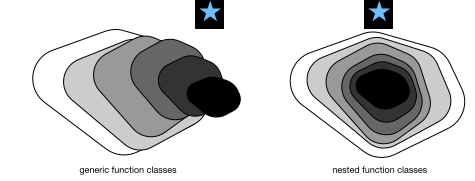

In [1]:
from IPython.display import SVG
SVG(filename="../img/functionclasses.svg")

Only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly
increases the expressive power of the network. This is the question that He et al, 2016 considered when
working on very deep computer vision models. At the heart of ResNet is the idea that every additional layer
should contain the identity function as one of its elements. This means that if we can train the newly-added
layer into an identity mapping $f (x) = x$, the new model will be as effective as the original model. As the
new model may get a better solution to fit the training data set, the added layer might make it easier to
reduce training errors. Even better, the identity function rather than the null $f (x) = 0$ should be the the
simplest function within a layer.
These considerations are rather profound but they led to a surprisingly simple solution, a residual block.
With it, He et al, $2015^{146}$ won the ImageNet Visual Recognition Challenge in 2015. The design had a
profound influence on how to build deep neural networks.

## Residual Blocks

Let us focus on a local neural network, as depicted below. Denote the input by $x$. We assume that the ideal
mapping we want to obtain by learning is $f (x)$, to be used as the input to the activation function. The
portion within the dotted-line box in the left image must directly fit the mapping $f (x)$. This can be tricky
if we don’t need that particular layer and we would much rather retain the input $x$. The portion within the
dotted-line box in the right image now only needs to parametrize the deviation from the identity, since we
return $x + f (x)$. In practice, the residual mapping is often easier to optimize. We only need to set $f (x) = 0$.
The right image in the figure below illustrates the basic Residual Block of ResNet. Similar architectures
were later proposed for sequence models which we will study later.

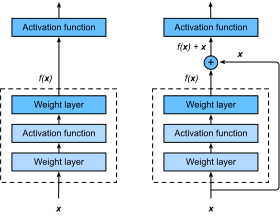

In [2]:
SVG(filename="../img/residual-block.svg")

ResNet follows VGG’s full 3 × 3 convolutional layer design. The residual block has two 3 × 3 convolutional
layers with the same number of output channels. Each convolutional layer is followed by a batch normal-
ization layer and a ReLU activation function. Then, we skip these two convolution operations and add the
input directly before the final ReLU activation function. This kind of design requires that the output of the
two convolutional layers be of the same shape as the input, so that they can be added together. If we want
to change the number of channels or the the stride, we need to introduce an additional 1 × 1 convolutional
layer to transform the input into the desired shape for the addition operation. Let’s have a look at the code
below.

In [3]:
import sys
sys.path.insert(0, '..')

import d2l
import torch
import torch.nn as nn
import torch.nn.functional as F

# This class has been saved in the d2l package for future use
class Residual(nn.Module):
  
  def __init__(self,input_channels, num_channels, use_1x1conv=False, strides=1, **kwargs):
    super(Residual, self).__init__(**kwargs)
    self.conv1 = nn.Conv2d(input_channels, num_channels,kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)
    self.relu = nn.ReLU(inplace=True)
  
  def forward(self, X):
    
    Y = self.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    Y =self.relu(Y)
    return Y

This code generates two types of networks: one where we add the input to the output before applying the
ReLU nonlinearity, and whenever use_1x1conv=True, one where we adjust channels and resolution by means
of a 1 × 1 convolution before adding. The diagram below illustrates this:

Now let us look at a situation where the input and output are of the same shape.

In [4]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

We also have the option to halve the output height and width while increasing the number of output channels.

In [5]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

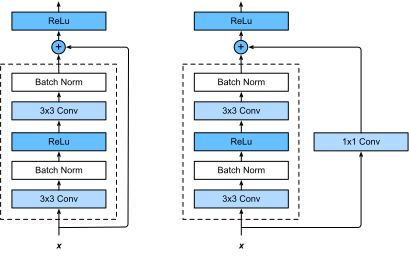

In [6]:
SVG(filename="../img/ResNetBlock.svg")

## ResNet Model

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the 7 × 7
convolutional layer with 64 output channels and a stride of 2 is followed by the 3 × 3 maximum pooling layer
with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in
ResNet.

In [7]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


GoogLeNet uses four blocks made up of Inception blocks. However, ResNet uses four modules made up of
residual blocks, each of which uses several residual blocks with the same number of output channels. The
number of channels in the first module is the same as the number of input channels. Since a maximum
pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width.
In the first residual block for each of the subsequent modules, the number of channels is doubled compared
with that of the previous module, and the height and width are halved.

Now, we implement this module. Note that special processing has been performed on the first module.

In [8]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels, num_channels))
  return blk

Then, we add all the residual blocks to ResNet. Here, two residual blocks are used for each module. Just like GoogLeNet, we add a global average pooling layer, followed by the fully connected layer
output.

In [9]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
b2=nn.Sequential(*resnet_block(64,64,2,first_block=True))
b3=nn.Sequential(*resnet_block(64,128,2))
b4=nn.Sequential(*resnet_block(128,256,2))
b5=nn.Sequential(*resnet_block(256,512,2))
net=nn.Sequential(b1,b2,b3,b4,b5,nn.AdaptiveMaxPool2d((1,1)),Flatten(),nn.Linear(512, 10))

There are 4 convolutional layers in each module (excluding the 1 × 1 convolutional layer). Together with
the first convolutional layer and the final fully connected layer, there are 18 layers in total. Therefore, this
model is commonly known as ResNet-18. By configuring different numbers of channels and residual blocks
in the module, we can create different ResNet models, such as the deeper 152-layer ResNet-152. Although
the main architecture of ResNet is similar to that of GoogLeNet, ResNet’s structure is simpler and easier to
modify. All these factors have resulted in the rapid and widespread use of ResNet. Below is a diagram of
the full ResNet-18.

## Data Acquisition and Training 

We train ResNet on the Fashion-MNIST data set, just like before. The only thing that has changed is the
learning rate that decreased again, due to the more complex architecture.

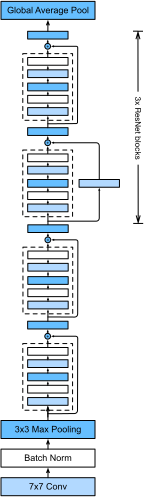

In [10]:
SVG(filename="../img/ResNetFull.svg")

In [9]:
lr, num_epochs, batch_size, device = 0.05, 5, 256, d2l.try_gpu()
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
criterion = nn.CrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch5(net, train_iter, test_iter, criterion, num_epochs, batch_size, device, lr)

training on cuda:0
epoch 1, loss 0.0031, train acc 0.795, test acc 0.618, time 52.1 sec
epoch 2, loss 0.0011, train acc 0.891, test acc 0.875, time 51.0 sec
epoch 3, loss 0.0009, train acc 0.914, test acc 0.883, time 51.4 sec
epoch 4, loss 0.0007, train acc 0.932, test acc 0.808, time 51.2 sec
epoch 5, loss 0.0006, train acc 0.945, test acc 0.885, time 51.2 sec


## Summary 

• Residual blocks allow for a parametrization relative to the identity function $f (x) = x$.

• Adding residual blocks increases the function complexity in a well-defined manner.

• We can train an effective deep neural network by having residual blocks pass through cross-layer data
channels.

• ResNet had a major influence on the design of subsequent deep neural networks, both for convolutional
and sequential nature.

## Exercises 

1. Refer to Table 1 in the $ResNet paper^{147}$ to implement different variants.
2. For deeper networks, ResNet introduces a “bottleneck” architecture to reduce model complexity. Try
to implement it.
3. In subsequent versions of ResNet, the author changed the “convolution, batch normalization, and
activation” architecture to the “batch normalization, activation, and convolution” architecture. Make
this improvement yourself. See Figure 1 in He et al., $2016^{148}$ for details.
4. Prove that if x is generated by a ReLU, the ResNet block does indeed include the identity function.
5. Why can’t we just increase the complexity of functions without bound, even if the function classes are
nested?

## References 

[1] He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings
of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

[2] He, K., Zhang, X., Ren, S., & Sun, J. (2016, October). Identity mappings in deep residual networks. In
European Conference on Computer Vision (pp. 630-645). Springer, Cham.